In [1]:
import pandas as pd
import glob
import numpy as np
pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [4]:
pwd

'C:\\Users\\plele\\Documents\\GitHub\\Mobilite'

In [5]:
glob.glob('./Tables_traitees/*')

['./Tables_traitees\\Communes_manquantes.csv',
 './Tables_traitees\\Infos_communes.csv',
 './Tables_traitees\\Infos_communes_avec_prix_estimé.csv',
 './Tables_traitees\\Merge_des_tables_sans_estimation_sans_df_elec&df_carb.csv',
 './Tables_traitees\\Population-Superficie_communes.csv',
 './Tables_traitees\\PrixMoy_m2_avec_code_commune.csv',
 './Tables_traitees\\Stations_carburant_avec_code_commune.csv',
 './Tables_traitees\\Stations_electriques_avec_code_commune.csv',
 './Tables_traitees\\Table_avec_prixM2_estime.csv',
 './Tables_traitees\\Table_avec_prixM2_estime_FranceMétropolitaine.csv']

| N° | Dataframe | Description |
| -- | -- | -- |  
| 1. | df_elec | Bornes électriques |
| 2. | df_carb | Stations Carburant | 
| 3. | df_pop | Population et superficie commune | 
| 4. | df_com | Infos communes | 
| 5. | df_commune_immo | Prix au m2 | 
| 6. | df_commune_adj | Communes adjacentes | |
|    | df | Dataframe regroupant pop, com, commune_immo et commune adj |
|    | df_train | =df moins 6000 valeurs, à utiliser pour l'entrainement des modèles, le reste sera pour comparer les estimations |
|    | df_m2 | =df_train filtré par les valeurs qui ont un prix au m2 |
|    | df_ridge | =df_train filtré par les valeurs qui ont un prix au m2 mais aussi filtré par les valeurs non NA de features |

In [6]:
# # Lecture du fichier des tables mergées
# df = pd.read_csv('./Tables_traitees/Merge_des_tables_sans_estimation_sans_df_elec&df_carb.csv',
#                  sep=';',dtype={'3_Code département':str, '3_Code INSEE (commune ou arrondissement)':str, 
#                                 '3_Code EPCI':str, '1_Code INSEE commune':str, '1_Num PDL':str,
#                                 '1_longitude':str, '1_code_commune_n':str, '2_Code INSEE':str,
#                                 '2_code_commune_n':str, '4_Code Postal':str, "5_INSEE_DEP":str, "5_ID":str,
#                                 "5_INSEE_COM":str,"5_code_commune_n":str,"6_insee":str,"4_Code INSEE":str,
#                                 "4_Code Département":str })

In [7]:
# # Lecture du fichier des tables mergées avec les estimations m2 déjà enregistrées
# df = pd.read_csv('./Tables_traitees/Table_avec_prixM2_estime.csv',
#                  sep=';',dtype={'3_Code département':str, '3_Code INSEE (commune ou arrondissement)':str, 
#                                 '3_Code EPCI':str, '1_Code INSEE commune':str, '1_Num PDL':str,
#                                 '1_longitude':str, '1_code_commune_n':str, '2_Code INSEE':str,
#                                 '2_code_commune_n':str, '4_Code Postal':str, "5_INSEE_DEP":str, "5_ID":str,
#                                 "5_INSEE_COM":str,"5_code_commune_n":str,"6_insee":str,"4_Code INSEE":str,
#                                 "4_Code Département": 'category' })

In [8]:
# Lecture du fichier des tables mergées avec les estimations m2 déjà enregistrées pour France Métropolitaine
df = pd.read_csv('./Tables_traitees/Table_avec_prixM2_estime_FranceMétropolitaine.csv',
                 sep=';',dtype={'3_Code département':'category', '3_Code INSEE (commune ou arrondissement)':str, 
                                '3_Code EPCI':str, '1_Code INSEE commune':str, '1_Num PDL':str,
                                '1_longitude':str, '1_code_commune_n':str, '2_Code INSEE':str,
                                '2_code_commune_n':str, '4_Code Postal':str, "5_INSEE_DEP":str, "5_ID":str,
                                "5_INSEE_COM":str,"5_code_commune_n":str,"6_insee":str,"4_Code INSEE":str,
                                "4_Code Département": 'category' ,'4_Statut':'category','4_Code Région':'category',
                               '3_Code Région':'category'})

In [9]:
df.shape

(36261, 65)

In [10]:
sorted(df.columns.to_list())

['3_Année recensement',
 '3_Année utilisation',
 '3_Code EPCI',
 '3_Code INSEE (commune ou arrondissement)',
 '3_Code commune',
 '3_Code département',
 '3_Code région',
 '3_Densité_hab_par_km2',
 '3_EPCI',
 '3_Nom de la commune',
 '3_Nom de la région',
 '3_Population comptée à part',
 '3_Population municipale',
 '3_Population totale',
 '3_Statut',
 '3_Superficie de la commune',
 '4_Altitude Moyenne',
 '4_Code Arrondissement',
 '4_Code Canton',
 '4_Code Commune',
 '4_Code Département',
 '4_Code INSEE',
 '4_Code Postal',
 '4_Code Région',
 '4_Commune',
 '4_Densité_hab_par_km2',
 '4_Département',
 '4_ID Geofla',
 '4_Population',
 '4_Région',
 '4_Statut',
 '4_Superficie',
 '4_geo_point_2d',
 '4_geo_shape',
 '4_lat',
 '4_lon',
 '5_CODE_EPCI',
 '5_ID',
 '5_INSEE_COM',
 '5_INSEE_DEP',
 '5_INSEE_REG',
 '5_NOM_COM_M',
 '5_Nb_Ventes',
 '5_POPULATION',
 '5_PrixMoyen_M2',
 '5_code_commune_n',
 '5_nb_digits_code_INSEE',
 '6_cap_voisins',
 '6_insee',
 '6_insee_voisins',
 '6_nb_voisins',
 '6_nom',
 '

In [11]:
# Valeurs uniques et manquant par colonne
df_analyse = []
manquantes = df.isna().sum()
for t in df.columns:
    row = {}
    row['Variable']=t
    row['type']= df[t].dtypes
    row['Nb_val_unique']=len(df[t].unique())
    row['Nb_manquant']=manquantes[t]
    df_analyse.append(row)
df_analyse = pd.DataFrame(df_analyse)
df_analyse.sort_values(by='Nb_manquant',ascending=False)

,Variable,type,Nb_val_unique,Nb_manquant
64,F_Prix_estimé_RFReg2,float64,1,36261
55,6_type,object,9,35501
25,5_Nb_Ventes,float64,553,9517
26,5_PrixMoyen_M2,float64,3683,9517
59,B_Prix_estimé_vois_median,float64,9575,1864
57,A_Prix_estimé_vois_mean,float64,29341,1864
52,6_insee_voisins,object,34449,1810
50,6_nom,object,32223,1810
51,6_nb_voisins,float64,23,1810
53,6_noms_voisins,object,34449,1810


In [12]:
df['3_Nom de la région'].unique()

array(['Auvergne-Rhône-Alpes', 'Rhône-Alpes', 'Hauts-de-France',
       'Picardie', 'Auvergne', "Provence-Alpes-Côte d'Azur", 'Grand Est',
       'Champagne-Ardenne', 'Grand-Est', 'Occitanie',
       'Languedoc-Roussillon', 'Midi-Pyrénées', 'Normandie',
       'Basse-Normandie', 'Nouvelle-Aquitaine', 'Poitou-Charentes',
       'Centre-Val de Loire', 'Limousin', 'Bourgogne-Franche-Comté',
       'Bourgogne', 'Bretagne', 'Aquitaine', 'Franche-Comté',
       'Haute-Normandie', 'Centre', 'Pays de la Loire', 'Lorraine',
       'Nord-Pas-de-Calais', 'Alsace', 'Île-de-France'], dtype=object)

In [13]:
# correction d'une ligne (la seule, dont la superficie et la densité n'étaient pas remplies
df.loc[31441, '3_Superficie de la commune'] = 8.71
df.loc[31441, '3_Densité_hab_par_km2'] = 254.0/8.71
# df.loc[31441,:]

- Choisissons d'abord une liste d'index de 6000 valeurs
- Nous n'utiliserons pas ces lignes pour les entrainements de modèles de ML, uniquement pour mesurer la précision de chaque modèle
- SVP pour entrainer vos modèles, utiliser désormais df_train
- Ensuite vous faites la prédictions sur tout le dataframe df
- Pour la comparaison on utilisera que les lignes correspondantes aux index_to_remove, ainsi on peut comparer les résultats sur des données non entrainées

In [14]:
France_metropolitaine = ['Auvergne-Rhône-Alpes', 'Rhône-Alpes', 'Hauts-de-France',
       'Picardie', 'Auvergne', "Provence-Alpes-Côte d'Azur", 'Grand Est',
       'Champagne-Ardenne', 'Grand-Est', 'Occitanie',
       'Languedoc-Roussillon', 'Midi-Pyrénées', 'Normandie',
       'Basse-Normandie', 'Nouvelle-Aquitaine', 'Poitou-Charentes',
       'Centre-Val de Loire', 'Limousin', 'Bourgogne-Franche-Comté',
       'Bourgogne', 'Bretagne', 'Aquitaine', 'Franche-Comté',
       'Haute-Normandie', 'Centre', 'Pays de la Loire',
       'Lorraine', 'Nord-Pas-de-Calais', 'Alsace', 'Île-de-France']

In [15]:
df = df[df['3_Nom de la région'].isin(France_metropolitaine)]
df_clean = df.drop(['F_Prix_estimé_RFReg2', '6_type', 'B_Prix_estimé_vois_median', 'A_Prix_estimé_vois_mean',
                   ], axis = 1)

In [16]:
df_no_na = df_clean[(df_clean['5_PrixMoyen_M2'].isna()==False) & (df_clean['6_nom'].isna()==False) & (df_clean['4_Commune'].isna()==False)]
df_no_na = df_no_na.reset_index(drop=True)

In [17]:
np.random.seed(97)
index_to_remove = np.random.randint(0,len(df_no_na)+1, size=6000)
df_train = df_no_na.drop(index_to_remove)

In [18]:
df_m2 = df_train

In [19]:
# Valeurs uniques par colonne
df_analyse = []
manquantes = df_m2.isna().sum()
for t in df_m2.columns:
    row = {}
    row['Variable']=t
    row['type']= df_m2[t].dtypes
    row['Nb_val_unique']=len(df_m2[t].unique())
    row['Nb_manquant']=manquantes[t]
    df_analyse.append(row)
df_analyse = pd.DataFrame(df_analyse)
df_analyse.sort_values(by='Nb_manquant',ascending=False)

,Variable,type,Nb_val_unique,Nb_manquant
0,Unnamed: 0.1,int64,21315,0
31,4_Commune,object,20199,0
33,4_Région,object,20,0
34,4_Statut,category,20,0
35,4_Altitude Moyenne,float64,1448,0
36,4_Superficie,float64,4621,0
37,4_Population,float64,425,0
38,4_geo_point_2d,object,21315,0
39,4_geo_shape,object,21315,0
40,4_ID Geofla,float64,21315,0


In [20]:
from sklearn.model_selection import KFold
nb_kfold = 5
rdm_state = 97
kf = KFold(n_splits=nb_kfold,shuffle=True, random_state = rdm_state)

# Estimation des manquants prix moyen m2 

On commence par choisir les variables qui vont participer à l'imputation

In [27]:
sel_col = ['3_Code INSEE (commune ou arrondissement)','3_Code département', '5_PrixMoyen_M2', 
           'A_Prix_estimé_vois_mean', 'A_Prix_consolidé_vois_mean', 'B_Prix_estimé_vois_median', 'B_Prix_consolidé_vois_median', 
           '6_insee_voisins']

## A-Par moyenne et B-médiane des communes avoisinantes

In [21]:
# On initialise les nouvelles variables
df_m2['A_Prix_consolidé_vois_mean'] = np.nan
df_m2['A_Prix_estimé_vois_mean'] = np.nan
df_m2['B_Prix_consolidé_vois_median'] = np.nan
df_m2['B_Prix_estimé_vois_median'] = np.nan
df_m2['5_PrixMoyen_M2'] = df_m2['5_PrixMoyen_M2'].astype(float)
# On initialise les nouvelles variables
df['A_Prix_consolidé_vois_mean'] = np.nan
df['A_Prix_estimé_vois_mean'] = np.nan
df['B_Prix_consolidé_vois_median'] = np.nan
df['B_Prix_estimé_vois_median'] = np.nan
df['5_PrixMoyen_M2'] = df['5_PrixMoyen_M2'].astype(float)

In [22]:
# On crée un dictionnaire pour aller plus vite dans la recherche des communes voisines 
voisins_dict = df.set_index('6_insee')['6_insee_voisins'].to_dict()
df_m2['A_Prix_consolidé_vois_mean'] = df_m2['5_PrixMoyen_M2']
df_m2['B_Prix_consolidé_vois_median'] = df_m2['5_PrixMoyen_M2']
df['A_Prix_consolidé_vois_mean'] = df['5_PrixMoyen_M2']
df['B_Prix_consolidé_vois_median'] = df['5_PrixMoyen_M2']

In [23]:
def estim_prix(code, vois, prix_mean, prix_median):
    try:
        # voisins = df_commune_adj.loc[df_commune_adj['insee']==code,'insee_voisins'].values[0].split('|')
        voisins = vois[str(code)].split('|')
        # print(voisins)
        prix_voisins_mean = list()
        prix_voisins_median = list()
        for v in voisins:
            try:
                # p = df.loc[df['Code INSEE (commune ou arrondissement)']==v,'Prix_consolidé'].values[0]
                p1 = prix_mean[str(v)]
                p2 = prix_median[str(v)]
            except:
                p1, p2 = None, None
            # nb = df.loc[df['Code INSEE (commune ou arrondissement)']==v,'Nb_Ventes'].values[0]
            prix_voisins_mean.append(float(p1))
            prix_voisins_median.append(float(p2))
        # print(code, voisins,prix_voisins)
        mean = np.nanmean(prix_voisins_mean)
        median = np.nanmedian(prix_voisins_median)
    except:
        mean = np.nan
        median = np.nan
    # print(code, mean, median)
    # print('-------')
    return pd.Series({'A_Prix_estimé_vois_mean': mean, 'B_Prix_estimé_vois_median': median})

In [24]:
%%time
n_iterations = 25
i=0
print('iteration:',i,'nbre de manquants:', sum(pd.isna(df['A_Prix_consolidé_vois_mean'])))
while i<n_iterations:
    Prix_consolidé_dict_mean = df.set_index('3_Code INSEE (commune ou arrondissement)')['A_Prix_consolidé_vois_mean'].to_dict()
    Prix_consolidé_dict_median = df.set_index('3_Code INSEE (commune ou arrondissement)')['B_Prix_consolidé_vois_median'].to_dict()
    df[['A_Prix_estimé_vois_mean', 'B_Prix_estimé_vois_median']] = df.apply(lambda x: estim_prix(x['3_Code INSEE (commune ou arrondissement)'], 
                                                                                      voisins_dict, Prix_consolidé_dict_mean, 
                                                                                      Prix_consolidé_dict_median ),axis=1)
    
    df['A_Prix_consolidé_vois_mean'] = df['A_Prix_estimé_vois_mean']
    df['B_Prix_consolidé_vois_median'] = df['B_Prix_estimé_vois_median']
    df.loc[pd.notna(df['5_PrixMoyen_M2']),'A_Prix_consolidé_vois_mean'] = df.loc[pd.notna(df['5_PrixMoyen_M2']), '5_PrixMoyen_M2'] 
    df.loc[pd.notna(df['5_PrixMoyen_M2']),'B_Prix_consolidé_vois_median'] = df.loc[pd.notna(df['5_PrixMoyen_M2']), '5_PrixMoyen_M2'] 
    nb_manquants = sum(pd.isna(df['A_Prix_consolidé_vois_mean']))
    i+=1
    print('iteration:',i,'nbre de manquants:',nb_manquants)

iteration: 0 nbre de manquants: 9517


C:\Users\plele\AppData\Local\Temp\ipykernel_9852\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\plele\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


iteration: 1 nbre de manquants: 3735


C:\Users\plele\AppData\Local\Temp\ipykernel_9852\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\plele\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


iteration: 2 nbre de manquants: 3200


C:\Users\plele\AppData\Local\Temp\ipykernel_9852\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\plele\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


iteration: 3 nbre de manquants: 2986


C:\Users\plele\AppData\Local\Temp\ipykernel_9852\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\plele\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


iteration: 4 nbre de manquants: 2833


C:\Users\plele\AppData\Local\Temp\ipykernel_9852\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\plele\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


iteration: 5 nbre de manquants: 2691


C:\Users\plele\AppData\Local\Temp\ipykernel_9852\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\plele\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


iteration: 6 nbre de manquants: 2558


C:\Users\plele\AppData\Local\Temp\ipykernel_9852\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\plele\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


iteration: 7 nbre de manquants: 2420


C:\Users\plele\AppData\Local\Temp\ipykernel_9852\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\plele\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


iteration: 8 nbre de manquants: 2293


C:\Users\plele\AppData\Local\Temp\ipykernel_9852\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\plele\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


iteration: 9 nbre de manquants: 2188


C:\Users\plele\AppData\Local\Temp\ipykernel_9852\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\plele\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


iteration: 10 nbre de manquants: 2105


C:\Users\plele\AppData\Local\Temp\ipykernel_9852\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\plele\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


iteration: 11 nbre de manquants: 2033


C:\Users\plele\AppData\Local\Temp\ipykernel_9852\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\plele\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


iteration: 12 nbre de manquants: 1961


C:\Users\plele\AppData\Local\Temp\ipykernel_9852\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\plele\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


iteration: 13 nbre de manquants: 1902


C:\Users\plele\AppData\Local\Temp\ipykernel_9852\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\plele\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


iteration: 14 nbre de manquants: 1847


C:\Users\plele\AppData\Local\Temp\ipykernel_9852\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\plele\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


iteration: 15 nbre de manquants: 1803


C:\Users\plele\AppData\Local\Temp\ipykernel_9852\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\plele\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


iteration: 16 nbre de manquants: 1775


C:\Users\plele\AppData\Local\Temp\ipykernel_9852\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\plele\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


iteration: 17 nbre de manquants: 1761


C:\Users\plele\AppData\Local\Temp\ipykernel_9852\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\plele\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


iteration: 18 nbre de manquants: 1753


C:\Users\plele\AppData\Local\Temp\ipykernel_9852\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\plele\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


iteration: 19 nbre de manquants: 1749
iteration: 20 nbre de manquants: 1747
iteration: 21 nbre de manquants: 1747
iteration: 22 nbre de manquants: 1747
iteration: 23 nbre de manquants: 1747
iteration: 24 nbre de manquants: 1747
iteration: 25 nbre de manquants: 1747
CPU times: total: 5min 27s
Wall time: 7min 51s


In [25]:
sum(pd.isna(df_m2['A_Prix_estimé_vois_mean']))

21315

In [26]:
df_m2.shape

(21315, 63)

In [27]:
df_vois_no_na = df[(df['5_PrixMoyen_M2'].isna()==False) & (df['6_nom'].isna()==False) & (df['4_Commune'].isna()==False)]
df_vois_no_na = df_vois_no_na.reset_index(drop=True)

2 cas pour ceux qui n'ont pas de prix consolidé
- soit ils n'ont pas de voisins identifiés
- soit ils ont des voisins mais n'ont pas de prix, en DOM TOM, départements 97X

In [28]:
print(len(df_vois_no_na[df_vois_no_na['5_PrixMoyen_M2'].isna()]))
print(len(df_vois_no_na[df_vois_no_na['A_Prix_consolidé_vois_mean'].isna()]))
print(len(df_vois_no_na[df_vois_no_na['B_Prix_consolidé_vois_median'].isna()]))

0
0
0


In [29]:
df_vois_no_na[df_vois_no_na['A_Prix_estimé_vois_mean'].isna() & df_vois_no_na['A_Prix_consolidé_vois_mean'].notna()].head()

,Unnamed: 0.1,Unnamed: 0,3_Code région,3_Nom de la région,3_Code département,3_Code commune,3_Nom de la commune,3_Population municipale,3_Population comptée à part,3_Population totale,...,6_type,A_Prix_consolidé_vois_mean,A_Prix_estimé_vois_mean,B_Prix_consolidé_vois_median,B_Prix_estimé_vois_median,C_Prix_estime_mean,C1_Prix_estime_median,F_Prix_estimé_RFReg,G_Prix_estimé_LassoCV,F_Prix_estimé_RFReg2
3236,4405,4405,93.0,Provence-Alpes-Côte d'Azur,13,2.0,Allauch,21228.0,256.0,21484.0,...,NaN,3731.0,NaN,3731.0,NaN,1631.0,1448.0,3223.939101,3076.068077,NaN
3239,4408,4408,93.0,Provence-Alpes-Côte d'Azur,13,5.0,Aubagne,45290.0,421.0,45711.0,...,NaN,3046.0,NaN,3046.0,NaN,1631.0,1448.0,3046.551369,3257.772077,NaN
3256,4425,4425,93.0,Provence-Alpes-Côte d'Azur,13,22.0,Cassis,7162.0,103.0,7265.0,...,NaN,6303.0,NaN,6303.0,NaN,1631.0,1448.0,3635.166727,3040.238764,NaN
3302,4472,4472,93.0,Provence-Alpes-Côte d'Azur,13,70.0,La Penne-sur-Huveaune,6433.0,60.0,6493.0,...,NaN,3486.0,NaN,3486.0,NaN,1631.0,1448.0,3529.964141,3268.415305,NaN
3303,4473,4473,93.0,Provence-Alpes-Côte d'Azur,13,71.0,Les Pennes-Mirabeau,21361.0,276.0,21637.0,...,NaN,3457.0,NaN,3457.0,NaN,1631.0,1448.0,3225.796902,3133.772393,NaN


In [30]:
df_no_na['A_Prix_estimé_vois_mean'] = df_vois_no_na['A_Prix_estimé_vois_mean']
df_no_na['B_Prix_estimé_vois_median'] = df_vois_no_na['B_Prix_estimé_vois_median']

In [31]:
df_no_na[['5_PrixMoyen_M2', 'A_Prix_estimé_vois_mean', 'B_Prix_estimé_vois_median']].head()

,5_PrixMoyen_M2,A_Prix_estimé_vois_mean,B_Prix_estimé_vois_median
0,1938.0,2167.500000,2080.5
1,1130.0,1503.879310,1458.5
2,2005.0,1725.714286,1678.0
3,2442.0,2647.857143,2701.0
4,1155.0,1460.333333,1287.0


## C-Par moyenne et C1-mediane de toute la variable PAUL

In [32]:
df_m2['5_PrixMoyen_M2'].describe()

count    21315.000000
mean      1620.048135
std        817.529780
min        350.000000
25%       1098.000000
50%       1444.000000
75%       1920.500000
max      14803.000000
Name: 5_PrixMoyen_M2, dtype: float64

In [33]:
mean_value =  np.round(np.mean(df_m2.loc[df_m2['5_PrixMoyen_M2'].isna() == False, '5_PrixMoyen_M2']))
mean_value

1620.0

In [34]:
median_value = np.round(np.median(df_m2.loc[df_m2['5_PrixMoyen_M2'].isna() == False, '5_PrixMoyen_M2']))
median_value

1444.0

In [35]:
df_m2.loc['C_Prix_estime_mean'] = mean_value
df_m2.loc['C1_Prix_estime_median'] = median_value

df_m2.shape

(21317, 63)

## D-Par KNN OUMAR

In [36]:
# Delta= y_test - Y_pred

In [37]:
df_m2.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', '3_Code région', '3_Nom de la région',
       '3_Code département', '3_Code commune', '3_Nom de la commune',
       '3_Population municipale', '3_Population comptée à part',
       '3_Population totale', '3_Année recensement', '3_Année utilisation',
       '3_Code INSEE (commune ou arrondissement)',
       '3_Superficie de la commune', '3_Statut', '3_Code EPCI', '3_EPCI',
       '3_Densité_hab_par_km2', '5_ID', '5_INSEE_COM', '5_INSEE_DEP',
       '5_INSEE_REG', '5_CODE_EPCI', '5_NOM_COM_M', '5_POPULATION',
       '5_Nb_Ventes', '5_PrixMoyen_M2', '5_nb_digits_code_INSEE',
       '5_code_commune_n', '4_Code INSEE', '4_Code Postal', '4_Commune',
       '4_Département', '4_Région', '4_Statut', '4_Altitude Moyenne',
       '4_Superficie', '4_Population', '4_geo_point_2d', '4_geo_shape',
       '4_ID Geofla', '4_Code Commune', '4_Code Canton',
       '4_Code Arrondissement', '4_Code Département', '4_Code Région', '4_lat',
       '4_lon', '4_Densité_hab_p

## E-Par KNeighborsRegressor OUMAR

In [38]:
from sklearn.neighbors import KNeighborsRegressor 

data1=df_m2[['3_Code région', '3_Code département', '3_Population comptée à part', 
             '3_Population totale','3_Statut','3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '4_Superficie','4_Altitude Moyenne','4_lat','4_lon','5_PrixMoyen_M2']]
data1=data1.dropna()
data2=data1.sample(n=data1.shape[0],random_state=1)


data_train= data2[:16819]
data_test= data2[16820:data1.shape[0]]

X_train = data_train[['4_lat','4_lon']]
y_train=data_train[['5_PrixMoyen_M2']]
X_test = data_test[['4_lat','4_lon']]
y_test =data_test[['5_PrixMoyen_M2']]

neigh = KNeighborsRegressor(n_neighbors=10)

neigh.fit(X_train, y_train)

neigh.score(X_test,y_test)

0.6561352218401633

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Créer un pipeline avec StandardScaler et KNeighborsRegressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

# Définir la grille des paramètres à rechercher
param_grid = {
    'knn__n_neighbors': [5, 10, 15, 20, 25]  # Différentes valeurs du nombre de voisins à essayer
}

# Créer un objet GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')

# Adapter GridSearchCV sur les données d'entraînement
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres et le meilleur score
print("Meilleurs paramètres trouvés:", grid_search.best_params_)
print("Meilleur score sur la validation croisée:", grid_search.best_score_)

# Utiliser le modèle avec les meilleurs paramètres pour prédire sur les données de test
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Score sur les données de test avec les meilleurs paramètres:", test_score)

Meilleurs paramètres trouvés: {'knn__n_neighbors': 10}
Meilleur score sur la validation croisée: 0.6425582916558346
Score sur les données de test avec les meilleurs paramètres: 0.6573640046209639


C:\Users\plele\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


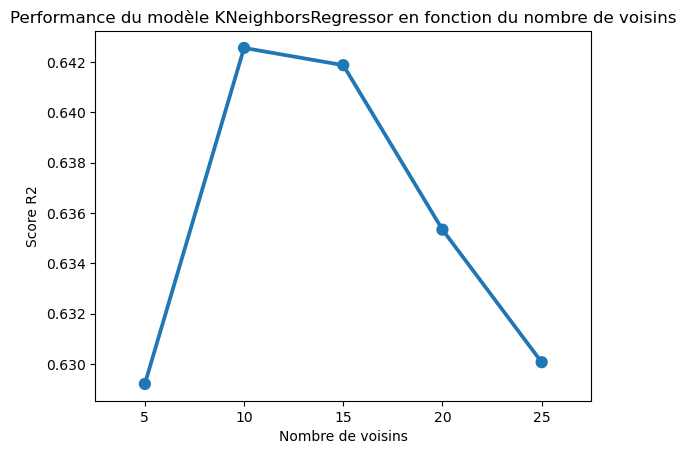

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extraire les valeurs de nombre de voisins testées et les scores correspondants
l_neighbors = [params['knn__n_neighbors'] for params in grid_search.cv_results_['params']]
res_knn_score = grid_search.cv_results_['mean_test_score']

# Tracer le graphique
sns.pointplot(x=l_neighbors, y=res_knn_score)
plt.xlabel('Nombre de voisins')
plt.ylabel('Score R2')
plt.title('Performance du modèle KNeighborsRegressor en fonction du nombre de voisins')
plt.show()


In [41]:
data2.head()

,3_Code région,3_Code département,3_Population comptée à part,3_Population totale,3_Statut,3_Population municipale,3_Densité_hab_par_km2,3_Superficie de la commune,4_Superficie,4_Altitude Moyenne,4_lat,4_lon,5_PrixMoyen_M2
7304,24.0,28,6.0,245.0,Commune,239.0,37.876387,6.31,630.0,178.0,48.516098,1.388661,1787.0
3232,76.0,12,707.0,12601.0,Commune,11894.0,260.034980,45.74,4574.0,349.0,44.349916,2.031033,1497.0
22044,28.0,76,8.0,801.0,Commune,793.0,144.181818,5.50,550.0,138.0,49.971667,1.440854,1533.0
22400,11.0,77,57.0,1438.0,Commune,1381.0,97.322058,14.19,1419.0,142.0,48.985178,3.142183,2152.0
23443,32.0,80,1.0,141.0,Commune,140.0,21.772939,6.43,643.0,93.0,50.071319,2.052793,667.0


In [42]:
df_no_na['E_Prix_estime_KNN']=best_model.predict(df_no_na[['4_lat','4_lon']])

In [43]:
df_no_na[['5_PrixMoyen_M2', 'E_Prix_estime_KNN']].head()

,5_PrixMoyen_M2,E_Prix_estime_KNN
0,1938.0,2034.4
1,1130.0,1647.3
2,2005.0,1752.7
3,2442.0,2468.1
4,1155.0,1353.6


In [44]:
df_no_na.shape

(26678, 64)

## F-Par RandomForestRegressor PAUL

In [45]:
# pd.set_option('display.max_columns', None)
df_m2.head()
# pd.reset_option('max_columns')

,Unnamed: 0.1,Unnamed: 0,3_Code région,3_Nom de la région,3_Code département,3_Code commune,3_Nom de la commune,3_Population municipale,3_Population comptée à part,3_Population totale,...,6_noms_voisins,6_cap_voisins,A_Prix_consolidé_vois_mean,B_Prix_consolidé_vois_median,C_Prix_estime_mean,C1_Prix_estime_median,F_Prix_estimé_RFReg,G_Prix_estimé_LassoCV,A_Prix_estimé_vois_mean,B_Prix_estimé_vois_median
0,0.0,0.0,84.0,Auvergne-Rhône-Alpes,01,1.0,L' Abergement-Clémenciat,767.0,18.0,785.0,...,Sulignat|Châtillon-sur-Chalaronne|Baneins|Domp...,48|144|203|234|260|322,1938.0,1938.0,1631.0,1448.0,1590.398336,1997.681268,NaN,NaN
1,1.0,1.0,84.0,Auvergne-Rhône-Alpes,01,2.0,L' Abergement-de-Varey,243.0,1.0,244.0,...,Boyeux-Saint-Jérôme|Nivollet-Montgriffon|Saint...,43|115|172|265|302|344,1130.0,1130.0,1631.0,1448.0,1398.761818,1938.198659,NaN,NaN
2,2.0,2.0,84.0,Auvergne-Rhône-Alpes,01,4.0,Ambérieu-en-Bugey,14081.0,437.0,14518.0,...,Saint-Rambert-en-Bugey|Torcieu|Bettant|Saint-D...,102|151|190|250|284|347|360,2005.0,2005.0,1631.0,1448.0,2341.409735,2108.273069,NaN,NaN
3,3.0,3.0,84.0,Auvergne-Rhône-Alpes,01,5.0,Ambérieux-en-Dombes,1671.0,34.0,1705.0,...,Sainte-Olive|Lapeyrouse|Monthieux|Saint-Jean-d...,43|102|145|193|230|272|310,2442.0,2442.0,1631.0,1448.0,1954.337259,2002.436347,NaN,NaN
4,4.0,4.0,84.0,Auvergne-Rhône-Alpes,01,6.0,Ambléon,110.0,6.0,116.0,...,Saint-Germain-les-Paroisses|Colomieu|Conzieu|L...,37|120|164|263|308|341,1155.0,1155.0,1631.0,1448.0,1362.887999,1917.910983,NaN,NaN


In [46]:
df_verif_na = df_m2.drop(['5_CODE_EPCI', '6_insee', '6_nom', '6_nb_voisins',
                          '6_insee_voisins', '6_noms_voisins', '6_cap_voisins'], axis=1)

In [47]:
# df_verif_na[df_verif_na.isna().any(axis=1)]

In [48]:
df_m2.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', '3_Code région', '3_Nom de la région',
       '3_Code département', '3_Code commune', '3_Nom de la commune',
       '3_Population municipale', '3_Population comptée à part',
       '3_Population totale', '3_Année recensement', '3_Année utilisation',
       '3_Code INSEE (commune ou arrondissement)',
       '3_Superficie de la commune', '3_Statut', '3_Code EPCI', '3_EPCI',
       '3_Densité_hab_par_km2', '5_ID', '5_INSEE_COM', '5_INSEE_DEP',
       '5_INSEE_REG', '5_CODE_EPCI', '5_NOM_COM_M', '5_POPULATION',
       '5_Nb_Ventes', '5_PrixMoyen_M2', '5_nb_digits_code_INSEE',
       '5_code_commune_n', '4_Code INSEE', '4_Code Postal', '4_Commune',
       '4_Département', '4_Région', '4_Statut', '4_Altitude Moyenne',
       '4_Superficie', '4_Population', '4_geo_point_2d', '4_geo_shape',
       '4_ID Geofla', '4_Code Commune', '4_Code Canton',
       '4_Code Arrondissement', '4_Code Département', '4_Code Région', '4_lat',
       '4_lon', '4_Densité_hab_p

In [49]:
from sklearn.ensemble import RandomForestRegressor 
# %%time
X_rf = df_m2[['4_lat','4_lon']]
y_rf = df_m2[['5_PrixMoyen_M2']]

l_profondeur = np.arange(13, 16, 1)
rf_score = []

for train, test in kf.split(X_rf):
    X_train = X_rf.iloc[train,:]
    y_train = y_rf.iloc[train]
    X_test = X_rf.iloc[test,:]
    y_test = y_rf.iloc[test]
    
    for prof in l_profondeur:
        rf = RandomForestRegressor(max_depth=prof, n_jobs = -1, random_state=0)
        # rf = make_pipeline(RandomForestRegressor(max_depth=prof, random_state=0, n_jobs = 10))
        rf.fit(X_train, y_train.values.ravel())
        rf_score.append(rf.score(X_test, y_test.values.ravel()))

res_rf_score = np.reshape(rf_score, [nb_kfold, l_profondeur.shape[0]])
res_rf_score = np.mean(res_rf_score, axis = 0)
indice_max = np.unravel_index(np.argmax(res_rf_score), res_rf_score.shape)
print('Indices Best score :', indice_max)
print('Best score :', np.max(res_rf_score))
print('Profondeur best score :', l_profondeur[indice_max])


Indices Best score : (1,)
Best score : 0.6429820736692424
Profondeur best score : 14


<Axes: >

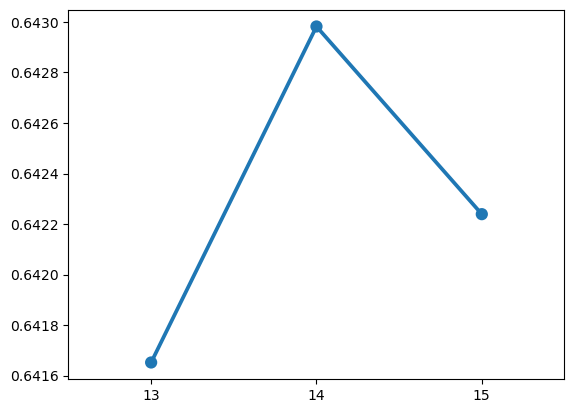

In [50]:
sns.pointplot(x=l_profondeur, y=res_rf_score)

In [51]:
rf = RandomForestRegressor(max_depth=14, n_jobs = -1, random_state=0)
rf.fit(X_train, y_train.values.ravel())

RandomForestRegressor(max_depth=14, n_jobs=-1, random_state=0)

In [52]:
rf.score(X_test, y_test.values.ravel())

0.6412179978064413

In [53]:
df_no_na['F_Prix_estimé_RFReg'] = np.nan
features_RF = ['4_lat','4_lon']
df_no_na['F_Prix_estimé_RFReg']=rf.predict(df_no_na[['4_lat','4_lon']])

In [54]:
df_m2.loc[:50,['5_PrixMoyen_M2','F_Prix_estimé_RFReg']]

,5_PrixMoyen_M2,F_Prix_estimé_RFReg
0,1938.0,1590.398336
1,1130.0,1398.761818
2,2005.0,2341.409735
3,2442.0,1954.337259
4,1155.0,1362.887999
5,1963.0,2092.972035
7,966.0,1421.492195
8,1970.0,1726.219815
9,889.0,1394.292512
10,1185.0,1371.675408


-------------------------------

## G-Par Lasso CV NICOLAS

In [55]:
# Sélection des caractéristiques
features = ['3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '4_Altitude Moyenne','4_lat','4_lon']

In [56]:
y = df_m2['5_PrixMoyen_M2']
X = df_m2[['3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune',
              '4_Altitude Moyenne','4_lat','4_lon']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
num_features = ['3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune',
              '4_Altitude Moyenne','4_lat','4_lon']
cat_features = []

for c in cat_features:
    X[c] = X[c].astype(object)

In [58]:
X.dtypes

3_Population municipale       float64
3_Densité_hab_par_km2         float64
3_Superficie de la commune    float64
4_Altitude Moyenne            float64
4_lat                         float64
4_lon                         float64
dtype: object

In [59]:
numeric_transformer = Pipeline(
    steps=[ 
        ("scaler", StandardScaler()),
    ])

categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))
          ])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ])

In [60]:
%%time
lasso_opti= Pipeline(
    steps=[
            ("preprocessor", preprocessor), 
           ("lassoCV", LassoCV(cv=5, random_state=0))])#BayesianRidge())]) #
lasso_opti.fit(X_train, y_train)
y_pred = lasso_opti.predict(X_test)

CPU times: total: 266 ms
Wall time: 747 ms


In [61]:
lasso_opti.named_steps.lassoCV.alphas_

array([305.01081091, 284.45410309, 265.28284857, 247.40367245,
       230.72949296, 215.17909736, 200.67674638, 187.15180531,
       174.53840001, 162.77509601, 151.80459933, 141.5734774 ,
       132.03189886, 123.13339077, 114.83461234, 107.09514381,
        99.87728955,  93.14589451,  86.86817297,  81.01354885,
        75.5535068 ,  70.46145331,  65.71258719,  61.28377874,
        57.15345716,  53.30150544,  49.70916236,  46.35893119,
        43.23449439,  40.32063417,  37.60315837,  35.06883135,
        32.70530949,  30.50108109,  28.44541031,  26.52828486,
        24.74036725,  23.0729493 ,  21.51790974,  20.06767464,
        18.71518053,  17.45384   ,  16.2775096 ,  15.18045993,
        14.15734774,  13.20318989,  12.31333908,  11.48346123,
        10.70951438,   9.98772896,   9.31458945,   8.6868173 ,
         8.10135489,   7.55535068,   7.04614533,   6.57125872,
         6.12837787,   5.71534572,   5.33015054,   4.97091624,
         4.63589312,   4.32344944,   4.03206342,   3.76

In [62]:
lasso_opti.named_steps.lassoCV.alpha_

0.3050108109076089

In [63]:
print("mse",mean_squared_error(y_test, y_pred))
print("r2", r2_score(y_test, y_pred))

mse 566622.4170876379
r2 0.1334124481456258


In [64]:
df_m2.loc[df_m2[features].isna().any(axis=1),features]

,3_Population municipale,3_Densité_hab_par_km2,3_Superficie de la commune,4_Altitude Moyenne,4_lat,4_lon


In [65]:
features

['3_Population municipale',
 '3_Densité_hab_par_km2',
 '3_Superficie de la commune',
 '4_Altitude Moyenne',
 '4_lat',
 '4_lon']

In [66]:
df_no_na['G_Prix_estimé_LassoCV'] = np.nan
df_no_na['G_Prix_estimé_LassoCV'] = lasso_opti.predict(df_no_na[features])

In [67]:
df_m2.loc[:40,['5_PrixMoyen_M2', 'G_Prix_estimé_LassoCV'] ]

,5_PrixMoyen_M2,G_Prix_estimé_LassoCV
0,1938.0,1997.681268
1,1130.0,1938.198659
2,2005.0,2108.273069
3,2442.0,2002.436347
4,1155.0,1917.910983
5,1963.0,2015.804048
7,966.0,1998.390373
8,1970.0,1910.028849
9,889.0,1827.666143
10,1185.0,1868.633911


## Comparaison des différents du prix moyen au m2 NICOLAS

In [68]:
# Valeurs uniques par colonne
df_analyse = []
manquantes = df_no_na.isna().sum()
for t in df_no_na.columns:
    row = {}
    row['Variable']=t
    row['type']= df_no_na[t].dtypes
    row['Nb_val_unique']=len(df_no_na[t].unique())
    row['Nb_manquant']=manquantes[t]
    df_analyse.append(row)
df_analyse = pd.DataFrame(df_analyse)
df_analyse.sort_values(by='Nb_manquant',ascending=False)

,Variable,type,Nb_val_unique,Nb_manquant
62,B_Prix_estimé_vois_median,float64,6840,54
61,A_Prix_estimé_vois_mean,float64,22222,54
0,Unnamed: 0.1,int64,26678,0
40,4_ID Geofla,float64,26678,0
45,4_Code Région,category,20,0
44,4_Code Département,category,90,0
43,4_Code Arrondissement,float64,7,0
42,4_Code Canton,float64,94,0
41,4_Code Commune,float64,903,0
38,4_geo_point_2d,object,26678,0


In [69]:
def performance_of_simulations(df, titre, list_of_sim):

    list_of_col = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'teal']
    
    print(f"{'RAPPEL: Nombre de prix moyen total / manquants:':50} {len(df)} / {len(df[df['5_PrixMoyen_M2'].isna()])}")
    
    plt.figure(figsize=(15,3.5*len(list_of_sim)))
    plt.suptitle(titre)
    
    for i,p in enumerate(list_of_sim):
        
        print(f"{'Simulation:':50} {p}")
        print(f"{'Nombre de prix estimés:':50} {len(df[df[p].notna()])}")

        df_eval = df.loc[index_to_remove,:].copy()
        df_not_NA = df_eval[(df_eval[p].notna()) & df_eval['5_PrixMoyen_M2'].notna()].copy()
        # df_not_NA = df[(df[p].notna()) & df['5_PrixMoyen_M2'].notna()].copy()
        print(f"{'Nombre de prix pour la comparaison:':50} {len(df_not_NA)}")
        
        mse = mean_squared_error( df_not_NA['5_PrixMoyen_M2'], df_not_NA[p])
        r2 = r2_score( df_not_NA['5_PrixMoyen_M2'], df_not_NA[p])
        
        df_not_NA['Delta_PrixMoyen_VS_estimé'] = df_not_NA[p] - df_not_NA['5_PrixMoyen_M2']

        plt.subplot(len(list_of_sim),3,3*i+1)
        sns.scatterplot(data=df_not_NA, x='5_PrixMoyen_M2', y=p, color=list_of_col[i])
        sns.lineplot(x=[0,10000], y=[0,10000],color='r')
        top = plt.gca().get_ylim()[1]
        plt.text(0, top-1000, s=p)
        plt.text(0,top-2000,s=f"mse: {round(mse)}")
        plt.text(0,top-3000,s=f"r2: {round(r2,3)}")
        if i<len(list_of_sim)-1: 
            plt.xlabel('')
        else:
            plt.xlabel('5_PrixMoyen_M2')

        plt.subplot(len(list_of_sim),3,3*i+2) 
        sns.histplot(x=df_not_NA['Delta_PrixMoyen_VS_estimé'], color=list_of_col[i])
        plt.xlim(-3000,3000)
        if i<len(list_of_sim)-1: 
            plt.xlabel('')
        else:
            plt.xlabel('Delta_PrixMoyen_VS_estimé')

        plt.subplot(len(list_of_sim),3,3*i+3)
        sns.boxplot(x=df_not_NA['Delta_PrixMoyen_VS_estimé'],orient='h', color=list_of_col[i])
        if i<len(list_of_sim)-1: 
            plt.xlabel('')
        else:
            plt.xlabel('Delta_PrixMoyen_VS_estimé')
        plt.xlim(-6000,6000)
        plt.text(-5500, -0.4, f"Mediane  :{round(np.median(df_not_NA['Delta_PrixMoyen_VS_estimé']))}")
        plt.text(-5500, -0.3, f"1st Qart.:{round(np.percentile(df_not_NA['Delta_PrixMoyen_VS_estimé'],25))}")
        plt.text(-5500, -0.2, f"3rd Qart.:{round(np.percentile(df_not_NA['Delta_PrixMoyen_VS_estimé'],75))}")
        plt.text(-5500, -0.1, f"IQR      :{round(np.percentile(df_not_NA['Delta_PrixMoyen_VS_estimé'],75)-np.percentile(df_not_NA['Delta_PrixMoyen_VS_estimé'],25))}")
        # print('Analyse de l"écart entre Prix Moyen réel et prix estimé')
        # print(df_not_NA['Delta_PrixMoyen_VS_estimé'].describe()) #
    plt.savefig("Comparaison des estimations du prix au M2.png")
    plt.show()

def performance_of_simulations2(df, titre, list_of_sim):

    list_of_col = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'teal']
    
    print(f"{'RAPPEL: Nombre de prix moyen total / manquants:':50} {len(df)} / {len(df[df['5_PrixMoyen_M2'].isna()])}")
    
    plt.figure(figsize=(15,3.5*len(list_of_sim)))
    plt.suptitle(titre)
    
    for i,p in enumerate(list_of_sim):
        
        print(f"{'Simulation:':50} {p}")
        print(f"{'Nombre de prix estimés:':50} {len(df[df[p].notna()])}")

        df_eval = df.loc[index_to_remove,:].copy()
        df_not_NA = df_eval[(df_eval[p].notna()) & df_eval['5_PrixMoyen_M2'].notna()].copy()
        # df_not_NA = df[(df[p].notna()) & df['5_PrixMoyen_M2'].notna()].copy()
        print(f"{'Nombre de prix pour la comparaison:':50} {len(df_not_NA)}")
        
        mse = mean_squared_error( df_not_NA['5_PrixMoyen_M2'], df_not_NA[p])
        r2 = r2_score( df_not_NA['5_PrixMoyen_M2'], df_not_NA[p])
        
        df_not_NA['Delta_PrixMoyen_VS_estimé'] = df_not_NA[p] - df_not_NA['5_PrixMoyen_M2']

        plt.subplot(len(list_of_sim),2,2*i+1)
        sns.scatterplot(data=df_not_NA, x='5_PrixMoyen_M2', y=p, color=list_of_col[i])
        sns.lineplot(x=[0,10000], y=[0,10000],color='r')
        top = plt.gca().get_ylim()[1]
        plt.text(0, top-1000, s=p)
        plt.text(0,top-2000,s=f"mse: {round(mse)}")
        plt.text(0,top-3000,s=f"r2: {round(r2,3)}")
        if i<len(list_of_sim)-1: 
            plt.xlabel('')
        else:
            plt.xlabel('5_PrixMoyen_M2')

        plt.subplot(len(list_of_sim),2,2*i+2)
        sns.violinplot(y=df_not_NA['Delta_PrixMoyen_VS_estimé'],orient='v', color=list_of_col[i])
        if i<len(list_of_sim)-1: 
            plt.xlabel('')
        else:
            plt.xlabel('Delta_PrixMoyen_VS_estimé')
        plt.ylim(-8000,8000)
        plt.text(-0.4, 7000, f"Mediane  :{round(np.median(df_not_NA['Delta_PrixMoyen_VS_estimé']))}")
        plt.text(-0.4, 6000, f"1st Qart.:{round(np.percentile(df_not_NA['Delta_PrixMoyen_VS_estimé'],25))}")
        plt.text(-0.4, 5000, f"3rd Qart.:{round(np.percentile(df_not_NA['Delta_PrixMoyen_VS_estimé'],75))}")
        plt.text(-0.4, 4000, f"IQR      :{round(np.percentile(df_not_NA['Delta_PrixMoyen_VS_estimé'],75)-np.percentile(df_not_NA['Delta_PrixMoyen_VS_estimé'],25))}")
        # print('Analyse de l"écart entre Prix Moyen réel et prix estimé')
        # print(df_not_NA['Delta_PrixMoyen_VS_estimé'].describe()) #
    plt.savefig("Comparaison des estimations du prix au M2-2.png")
    plt.show()

In [ ]:
performance_of_simulations(df_no_na.loc[index_to_remove],'Comparaison des estimations de prix',  
                           ['A_Prix_estimé_vois_mean', 'B_Prix_estimé_vois_median', 
                            'C_Prix_estime_mean', 
                            'C1_Prix_estime_median',
                            'E_Prix_estime_KNN',
                            'F_Prix_estimé_RFReg',  
                            #'F_Prix_estimé_RFReg2',
                            'G_Prix_estimé_LassoCV'
                           ])

RAPPEL: Nombre de prix moyen total / manquants:    6000 / 0
Simulation:                                        A_Prix_estimé_vois_mean
Nombre de prix estimés:                            5989
Nombre de prix pour la comparaison:                7367


C:\Users\plele\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plele\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plele\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Simulation:                                        B_Prix_estimé_vois_median
Nombre de prix estimés:                            5989
Nombre de prix pour la comparaison:                7367


C:\Users\plele\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plele\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plele\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


RAPPEL: Nombre de prix moyen total / manquants:    6000 / 0
Simulation:                                        C_Prix_estime_mean
Nombre de prix estimés:                            6000
Nombre de prix pour la comparaison:                7378
Simulation:                                        C1_Prix_estime_median
Nombre de prix estimés:                            6000
Nombre de prix pour la comparaison:                7378
Simulation:                                        E_Prix_estime_KNN
Nombre de prix estimés:                            6000
Nombre de prix pour la comparaison:                7378
Simulation:                                        F_Prix_estimé_RFReg
Nombre de prix estimés:                            6000
Nombre de prix pour la comparaison:                7378
Simulation:                                        G_Prix_estimé_LassoCV
Nombre de prix estimés:                            6000
Nombre de prix pour la comparaison:                7378


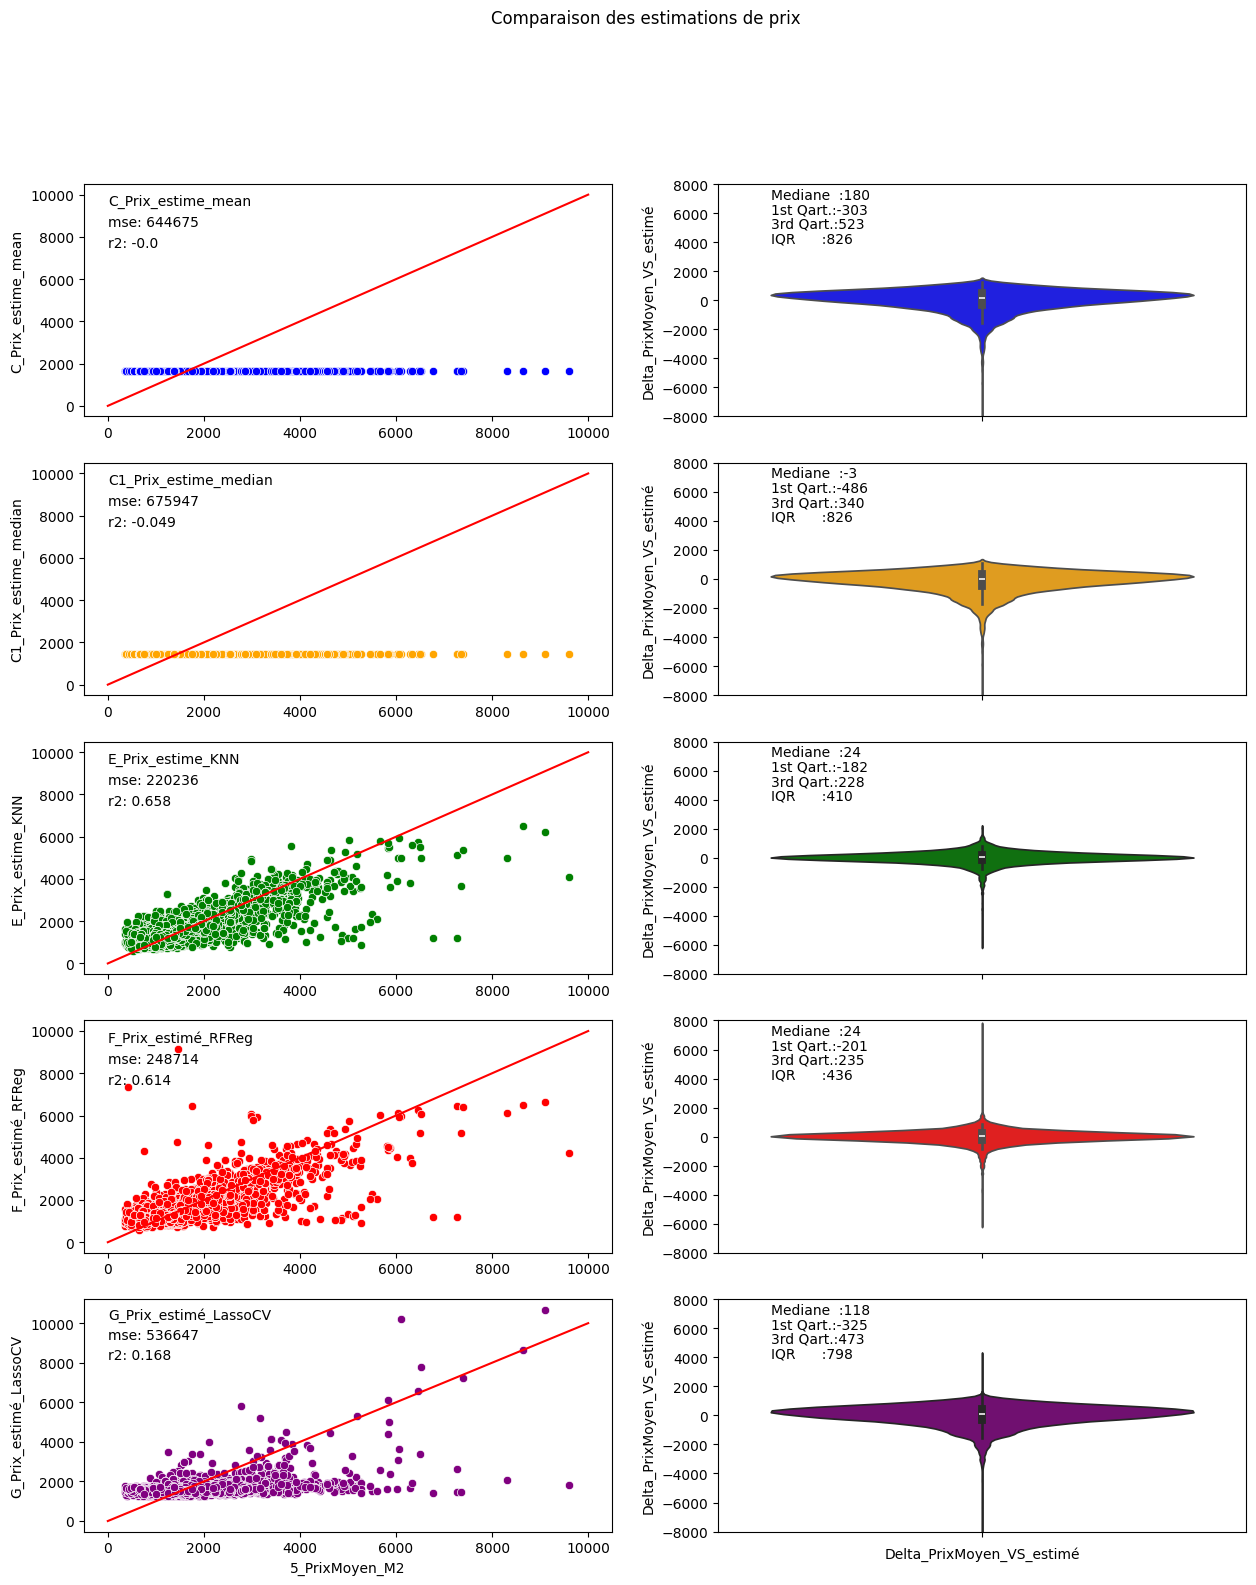

In [146]:
performance_of_simulations2(df_no_na.loc[index_to_remove],'Comparaison des estimations de prix',  
                           ['A_Prix_estimé_vois_mean', 'B_Prix_estimé_vois_median', 
                            'C_Prix_estime_mean', 
                            'C1_Prix_estime_median',
                            'E_Prix_estime_KNN',
                            'F_Prix_estimé_RFReg',  
                            #'F_Prix_estimé_RFReg2',
                            'G_Prix_estimé_LassoCV'
                           ])

## Sauvegarde des datas

In [98]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', '3_Code région', '3_Nom de la région',
       '3_Code département', '3_Code commune', '3_Nom de la commune',
       '3_Population municipale', '3_Population comptée à part',
       '3_Population totale', '3_Année recensement', '3_Année utilisation',
       '3_Code INSEE (commune ou arrondissement)',
       '3_Superficie de la commune', '3_Statut', '3_Code EPCI', '3_EPCI',
       '3_Densité_hab_par_km2', '5_ID', '5_INSEE_COM', '5_INSEE_DEP',
       '5_INSEE_REG', '5_CODE_EPCI', '5_NOM_COM_M', '5_POPULATION',
       '5_Nb_Ventes', '5_PrixMoyen_M2', '5_nb_digits_code_INSEE',
       '5_code_commune_n', '4_Code INSEE', '4_Code Postal', '4_Commune',
       '4_Département', '4_Région', '4_Statut', '4_Altitude Moyenne',
       '4_Superficie', '4_Population', '4_geo_point_2d', '4_geo_shape',
       '4_ID Geofla', '4_Code Commune', '4_Code Canton',
       '4_Code Arrondissement', '4_Code Département', '4_Code Région', '4_lat',
       '4_lon', '4_Densité_hab_p

In [81]:
# df.to_csv('./Tables_traitees/Table_avec_prixM2_estime_FranceMétropolitaine.csv', sep=';')